In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
...                    [2, 0], [2, 1], [2, 2]])

In [3]:
points

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])

In [4]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [5]:
vor = Voronoi(points)

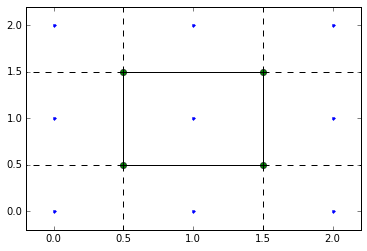

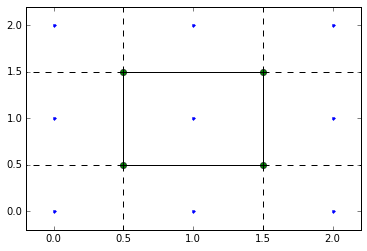

In [6]:
voronoi_plot_2d(vor)


In [7]:
points = np.random.rand(10,2)

In [8]:
vor = Voronoi(points)

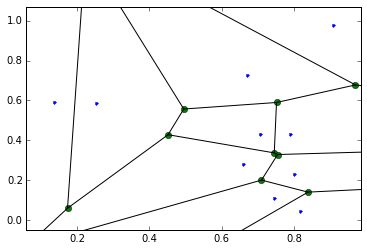

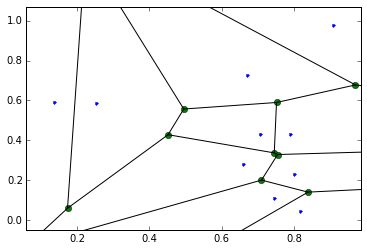

In [9]:
voronoi_plot_2d(vor)



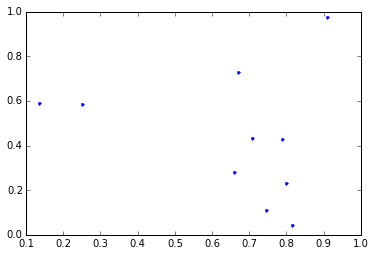

In [10]:
plot(points[:,0],points[:,1],'.')

In [11]:
import pysal as ps

In [12]:
segments = [[[2.0,3.0], [2.0, 4.0]], [[7.0,10],[8,5]]]

In [13]:
for seg in segments:
    print seg

[[2.0, 3.0], [2.0, 4.0]]
[[7.0, 10], [8, 5]]


In [14]:
R = ps.cg.Rtree()

In [17]:
t = ps.cg.RTree()

In [18]:
t.insert('a', ps.cg.Rect(0,0,10,10))

In [19]:
t.insert('b', ps.cg.Rect(5,5,20,20))

In [20]:
t.count

3

In [21]:
t.query_point((30,30))

<generator object query_point at 0x10c5af820>

In [22]:
for r in t.query_point((7,7)):
    print r

In [23]:
res = [ r.leaf_obj() for r in t.query_point((7,7)) if r.is_leaf()]

In [29]:
eb = ps.open(ps.examples.get_path("eberly_net.shp"))

In [31]:
chains = [ chain for chain in eb]

In [ ]:
eb.

In [32]:
chains

In [33]:
c0 = chains[0]

In [34]:
c0.bounding_box

<pysal.cg.shapes.Rectangle instance at 0x10c5e2518>

In [143]:
rt = ps.cg.Rtree()
SMALL = 0.01
node2segs = {}
for chain in chains[1:]:
    x0,y0,x1,y1 =  chain.bounding_box
    if (x0,y0) not in node2segs:
        node2segs[(x0,y0)] = []
    if (x1,y1) not in node2segs:
        node2segs[(x1,y1)] = []
    node2segs[(x0,y0)].append(chain)
    node2segs[(x1,y1)].append(chain)
    x0 -= SMALL
    y0 -= SMALL
    x1 += SMALL
    y1 += SMALL
    #print x0,y0,x1,y1
    r = ps.cg.Rect(x0,y0,x1,y1)
    #print r.area()
    rt.insert(chain, r)
   

In [144]:
kt = ps.cg.KDTree(node2segs.keys())

In [244]:
p = 1.8,4.046
dmin,node = kt.query(p,k=1)
node = kt.data[node]
print dmin,dmin**2, node

0.49610079621 0.246116 [ 2.   4.5]


In [245]:
x0 = node[0] - dmin
y0 = node[1] - dmin
x1 = node[0] + dmin
y1 = node[1] + dmin

In [246]:
x0,y0,x1,y1

(1.5038992037901977,
 4.0038992037901977,
 2.4961007962098023,
 4.9961007962098023)

In [247]:
candidates = [ cand for cand in rt.intersection([x0,y0,x1,y1])]


In [248]:
candidates

In [249]:
for candidate in candidates:
    print candidate.vertices
    p0,p1 = candidate.vertices
    

[(3.0, 5.0), (2.0, 4.5)]
[(0.0, 4.0), (5.0, 4.0)]


In [384]:
def squaredDistance(point, segment):
    """Find the squared distance between a point and a segment
    
    Arguments
    =========
    
    point: tuple (x,y)
    
    segment: list of tuples [(x0,y0), (x1,y1)]
    
    Returns
    =======
    
    tuple: 2 elements
    
           distance squared between point and segment
    
           array(xb,yb): the nearest point on the segment
    
    """
    p0,p1 = [np.array(p) for p in segment]
    v = p1 - p0
    p = np.array(point)
    w = p - p0
    c1 = np.dot(w,v)
    if c1 <= 0.:
        # print 'before p0'
        return np.dot(w.T,w), p0
    c2 = np.dot(v,v)
    if c2 <= c1:
        dp1 = p - p1
        # print 'after p1'
        return np.dot(dp1.T,dp1), p1
    
    b = c1 / c2
    bv = np.dot(b,v)
    pb = p0 + bv
    d2 = p - pb
    
    return np.dot(d2,d2), pb
    
    

In [377]:
p = (-2.,10.)
segment = (0.,0.),(10.,0.)
squaredDistance(p,segment)

(104.0, array([ 0.,  0.]))

In [378]:
p = (-2.,0)
segment = (0.,0.),(10.,0.)
squaredDistance(p,segment)

(4.0, array([ 0.,  0.]))

In [379]:
p = (-2.,-10.0)
segment = (0.,0.),(10.,0.)
squaredDistance(p,segment)

(104.0, array([ 0.,  0.]))

In [380]:
p = (2.,-2)
segment = (0.,0.),(10.,0.)
squaredDistance(p,segment)

(4.0, array([ 2.,  0.]))

In [381]:
p = (4.,-2)
segment = (0.,0.),(10.,0.)
squaredDistance(p,segment)

(4.0, array([ 4.,  0.]))

In [382]:
p = 1.8,4.046


for candidate in candidates:
    print squaredDistance(p, candidate.vertices), candidate.vertices
    print "\n"

(0.24611599999999975, array([ 2. ,  4.5])) [(3.0, 5.0), (2.0, 4.5)]


(0.0021160000000000241, array([ 1.8,  4. ])) [(0.0, 4.0), (5.0, 4.0)]




In [383]:
p = (2.,-2)
segment = (100.,0.),(100.,-10.)
squaredDistance(p,segment)

(9604.0, array([ 100.,   -2.]))